<a href="https://www.kaggle.com/code/duygukranolu/bal-k-g-r-nt-s-n-fland-rmas-derin-renme-ann?scriptVersionId=231959802" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<div class="alert alert-block" style="background-color: #00b7eb;">
  <span style="color:#2c3e50; font-weight: bold; font-size: 26px;"> 🎣 Balık Görüntü Sınıflandırması: Derin Öğrenme (ANN) Yaklaşımı</span>
</div>

<h3>Veri Seti Hakkında Bilgiler:</h3>
<ul style="background-color: #e3f2fd; padding: 15px; border-radius: 10px;">
        Bu veri seti, İzmir'deki bir süpermarketten toplanan 9 farklı deniz ürünü türüne ait görüntüler içermektedir. Veri seti, İzmir Ekonomi Üniversitesi ve bir sanayi kuruluşunun iş birliğiyle yürütülen üniversite-sanayi ortaklık projesi kapsamında toplanmış ve bu çalışma ASYU 2020'de yayınlanmıştır. <br>Veri seti, gilt head bream, red sea bream, sea bass, red mullet, horse mackerel, black sea sprat, striped red mullet, trout ve shrimp türlerine ait görüntü örneklerinden oluşmaktadır. 
</ul>

<h3>Proje Yaklaşımı:</h3>
<ul style="background-color: #e3f2fd; padding: 15px; border-radius: 10px;">
  Bu projede, balık türlerinin sınıflandırılması amaçlanmaktadır. Genelde bu tür sınıflandırma görevleri için Convolutional Neural Network (CNN) kullanılır. CNN'ler, en kaba haliyle iki ana bölümden oluşur:
    <br><li>Özellik Çıkarımı (görüntüdeki nesneleri birbirinden ayırt edebilmek için anlamlı özellikler oluşturma)</li>
    <li>Klasik Sinir Ağı Katmanı (elde edilen bu özellikleri kullanarak sınıflandırma yapma).</li><br>
   📌 Ancak bu projede, CNN kullanmak yerine yalnızca Yapay Sinir Ağı (ANN) kullanarak sınıflandırma yapılmaktadır. Özellik çıkarımı aşaması olmadan, görüntüler doğrudan ANN'e verilmiş ve balık türlerinin doğru şekilde sınıflandırılması sağlanmıştır.
</ul>

<h3>Projenin  Amacı:</h3>
<ul style="background-color: #e3f2fd; padding: 15px; border-radius: 10px;">
Bu projenin amacı, ANN kullanarak balık türlerini doğru şekilde sınıflandırmak ve modelin genelleme kabiliyetini artırmaktır. Genelleme kabiliyeti, modelin daha önce görmediği yeni verileri doğru şekilde tahmin edebilme yeteneğidir. Ancak, aşırı öğrenme (overfitting) bu kabiliyeti engelleyebilir. Bu sorunu aşmak için early stopping ve dropout gibi yöntemler kullanılmıştır. Ek olarak, hiperparametre optimizasyonu yapılmıştır.
</ul>

<a class="anchor" id="import"></a>

## <span style="color:#FA8072">  Kütüphanelerin Import Edilmesi </span> <a class="anchor" id="import_libraries"></a>

In [2]:
!pip install scikeras

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import collections

import warnings
warnings.filterwarnings("ignore")

import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix
from scikeras.wrappers import KerasClassifier



from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Rescaling, Input, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.initializers import RandomNormal, RandomUniform, GlorotUniform, GlorotNormal, HeNormal
from keras.optimizers.schedules import ExponentialDecay
from keras_tuner import RandomSearch, GridSearch, BayesianOptimization
from keras_tuner.engine.hyperparameters import HyperParameters

<a class="anchor" id="read"></a>

## <span style="color:#FA8072">  Veri Setini Okuma </span> <a class="anchor" id="load_data"></a>

In [4]:
label = []
path = []
fish_dir = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'

for dir_name, _, filenames in os.walk(fish_dir):
    for filename in filenames:
        if os.path.splitext(filename)[-1] == '.png':
            if dir_name.split()[-1] != 'GT':
                label.append(os.path.split(dir_name)[-1])
                path.append(os.path.join(dir_name, filename))
                
data = pd.DataFrame(columns=['path', 'label'])
data['path'] = path
data['label'] = label

<p style="background-color: #FFDAB9; padding: 15px; border-radius: 10px;">
Bu kod, balık fotoğraflarının dosya yollarını ve ilgili sınıf etiketlerini belirler. .png uzantılı dosyalar ve bu dosyaların etiketleri, listelere eklenir. Ardından, bu veriler path ve label sütunlarına sahip bir pandas DataFrame'e kaydedilir. Böylece, balık fotoğrafları etiketlenmiş ve model eğitimi veya analiz yapmak için hazır hale getirilmiş olur.
    <br><br> Özetle:  Bu kodun ile balık fotoğraflarının dosya yollarını ve etiketlerini içeren bir pandas DataFrame oluşturulmuştur.
</p>

<a class="anchor" id="read"></a>

## <span style="color:#FA8072">  Keşifsel Veri Analizi </span> <a class="anchor" id="load_data"></a>

In [5]:
# data adlı veri çerçevesinin kaç satır ve kaç sütundan oluştuğunu ekrana yazdırır
print(f" Count of Rows : {data.shape[0]} \n Count of Columns : {data.shape[1]} ")

# data.shape[0]: Veri çerçevesindeki toplam satır sayısını(9000) ifade eder
# data.shape[1]: Veri çerçevesindeki toplam sütun sayısını(2) ifade eder

 Count of Rows : 9000 
 Count of Columns : 2 


In [6]:
# Örnek veri kontrolü ve veri inceleme
print(data.head())
print(f"Toplam Fotoğraf Sayısı: {len(data)}")
print(f"Sınıf Dağılımı:\n{data['label'].value_counts()}")

                                                path            label
0  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
1  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
2  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
3  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
4  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
Toplam Fotoğraf Sayısı: 9000
Sınıf Dağılımı:
label
Hourse Mackerel       1000
Black Sea Sprat       1000
Sea Bass              1000
Red Mullet            1000
Trout                 1000
Striped Red Mullet    1000
Shrimp                1000
Gilt-Head Bream       1000
Red Sea Bream         1000
Name: count, dtype: int64


<p style="background-color: #FFDAB9; padding: 15px; border-radius: 10px;">
Veri setimizde toplam 9 farklı balık türü bulunmaktadır ve her türden 1000 fotoğraf vardır. <br> Bu, her sınıfın eşit sayıda gözleme sahip olduğunu ve dengeli bir veri seti olduğunu gösterir.
    <br>
</p>


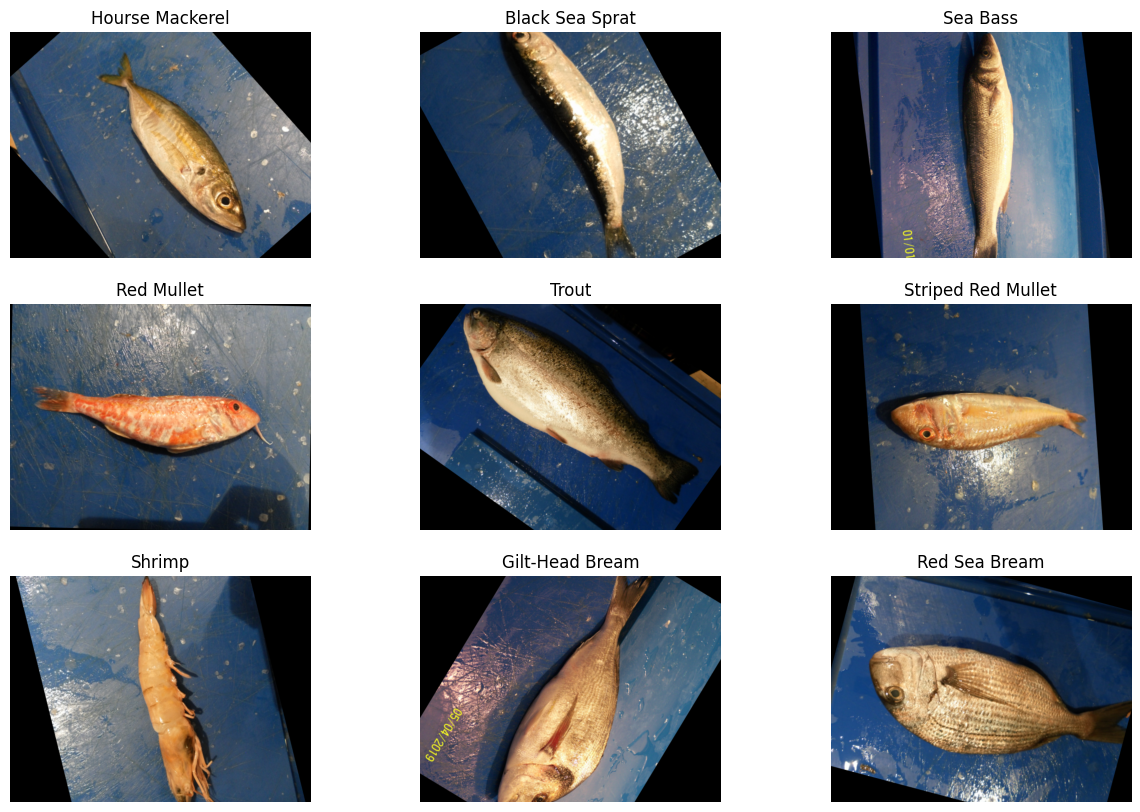

In [7]:
# Her tür balıktan yalnızca bir örnek almak için veriyi gruplama
unique_fish = data.drop_duplicates(subset=['label'])

# Görselleştirme
plt.figure(figsize=(15, 10))

for i, (index, row) in enumerate(unique_fish.iterrows()):
    plt.subplot(3, 3, i + 1)
    img = cv2.imread(row['path'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(row['label'])
    plt.axis('off')

plt.show()

<a class="anchor" id="read"></a>

## <span style="color:#FA8072">  Veri Setini Ayırma </span> <a class="anchor" id="load_data"></a>

In [8]:
# Veriyi eğitim ve test veri setlerine ayırır.
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=True, random_state=53)

print(train_data.shape)  # Eğitim veri setinin satır ve sütun sayısını gösterir.
print(test_data.shape)   # Test veri setinin satır ve sütun sayısını gösterir.

(7200, 2)
(1800, 2)


<p style="background-color: #FFDAB9; padding: 15px; border-radius: 10px;">
  <span style="font-weight: bold;"></span>  Veri setimiz, ilk olarak <span style="font-weight: bold;">train_test_split</span> kullanılarak test_size=0.2, %80 eğitim ve %20 test olarak ikiye bölünür. Daha sonra <span style="font-weight: bold;"> ImageDataGenerator</span> kullanarak, eğitim verisinin %20'sini doğrulama (validation) seti olarak ayırıyoruz (validation_split=0.2). Bu sayede:<br><br>
  • <span style="font-weight: bold;">Eğitim Seti (%64):</span>Modelin öğrenmesi için kullanılır. Model, bu verilerden sınıflar arasındaki ilişkileri öğrenir ve kendini eğitir.<br><br>
  • <span style="font-weight: bold;">Doğrulama Seti (%16):</span>Eğitim sırasında modelin performansını izleriz. Her eğitim döngüsünde modelin ne kadar iyi öğrendiğini gösterir ve aşırı öğrenme olup olmadığını kontrol ederiz. Doğrulama seti olmadan, modelin ezber yapıp yapmadığını fark edemez ve bu da yeni verilerde kötü sonuçlara yol açabilir.<br><br>
  • <span style="font-weight: bold;">Test Seti (%20):</span>Eğitim tamamlandıktan sonra modelin yeni ve daha önce görmediği veriler üzerindeki başarısını ölçmek için kullanılır. Bu set, modelin gerçek dünyadaki performansını değerlendirmemizi sağlar.<br><br>
</p>

<p style="background-color: #FFDAB9; padding: 15px; border-radius: 10px;"> <br>
  • <span style="font-weight: bold;">random_state=53:</span>Her çalıştırmada aynı veri bölmesini sağlar, böylece sonuçlar tutarlı olur ve her defasında aynı eğitim ve test setleri elde edilir.<br>Sayının kendisi özel bir anlam taşımaz; başka bir sayı da kullanılabilir.<br><br>
  • <span style="font-weight: bold;">shuffle=True:</span>Verileri rastgele karıştırır, böylece modelin sıralı verilere bağlı kalması engellenir ve bu da modelin genelleme kabiliyetini artırır. Verilerin homojen dağılımını sağlar.<br><br>
 
</p>

<p style="background-color: #FFDAB9; padding: 15px; border-radius: 10px;">
       🟧 Eğitim ve doğrulama setlerini ayırmak için alternatif olarak, veri setini manuel bir şekilde üç bölüme (eğitim, doğrulama, test) ayırabilirdik. Ancak bu yöntem süreci daha karmaşık hale getirebilir. Bunun yerine, ImageDataGenerator kullanarak validation_split parametresiyle doğrulama setini otomatik olarak ayırmak, daha pratik ve daha hızlı bir yöntemdir. Bu nedenle bu yöntemi tercih ediyorum.
</p>

<a class="anchor" id="read"></a>

## <span style="color:#FA8072">  Ön İşleme ve Veri Akışı Oluşturma </span> <a class="anchor" id="load_data"></a>

In [9]:
# ImageDataGenerator Nesnelerinin Oluşturulması(train_generator, test_generator)
train_generator = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

<p style="background-color: #FFDAB9; padding: 15px; border-radius: 10px;">
   Bu kod ile iki <span style="font-weight: bold;">ImageDataGenerator nesnesi</span> oluşturuyoruz: train_generator eğitim ve doğrulama seti için, test_generator ise test verileri için kullanılıyor.<br> Bu nesneler, verilerin normalizasyonunu yaparak modelin anlayabileceği formata dönüştürür. <span style="font-weight: bold;">preprocessing_function=preprocess_input parametresi</span>, verilerin normalleştirilmesini sağlar ve bu sayede veriler modelin öğrenmesi için uygun hale gelir.<br>
    Ayrıca, validation_split=0.2 kullanarak, eğitim verisinin %20'sini doğrulama seti olarak ayırıyoruz. Böylece, aynı train_data seti içinden hem eğitim hem de doğrulama setleri oluşturulmuş oluyor.<br>
</p>

<ul style="background-color: #FFDAB9; padding: 15px; border-radius: 10px;">
  <span style="font-weight: bold;">🟧 Veri Artırımı (Data Augmentation)</span><br> Bu noktada, veriler üzerinde herhangi bir veri artırımı (data augmentation) yapılmadı. Sadece normalizasyon işlemi yapıldı.<br>
      • Eğer veri artırımı yapmak isteseydik, ImageDataGenerator'ın rotation_range, width_shift_range, height_shift_range gibi ek parametrelerini kullanabilirdik.⬇️<br><br>

</ul>

In [ ]:
# train_generator = ImageDataGenerator(
#    preprocessing_function=preprocess_input, 
#    validation_split=0.2,
#    rotation_range=30,          # Döndürme
#    width_shift_range=0.2,      # Yatay kaydırma
#    height_shift_range=0.2,     # Dikey kaydırma
#    zoom_range=0.2,             # Yakınlaştırma
#    horizontal_flip=True        # Yatay çevirme
#)

In [10]:
# Veri Akışlarının Oluşturulması (flow_from_dataframe)
x_train = train_generator.flow_from_dataframe(dataframe=train_data, x_col='path', y_col='label', target_size=(224, 224), color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=True, seed=53, subset='training')

x_val = train_generator.flow_from_dataframe(dataframe=train_data, x_col='path', y_col='label', target_size=(224, 224), color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=True, seed=53, subset='validation' )

x_test = test_generator.flow_from_dataframe(dataframe=test_data, x_col='path', y_col='label', target_size=(224, 224), color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=False )

Found 5760 validated image filenames belonging to 9 classes.
Found 1440 validated image filenames belonging to 9 classes.
Found 1800 validated image filenames belonging to 9 classes.


<p style="background-color: #FFDAB9; padding: 15px; border-radius: 10px;">
  Bu kod, train_generator ve test_generator nesneleri ile belirli parametreler kullanarak:<br><br>
  •  <span style="font-weight: bold;">x_train:</span> Modelin eğitim sürecinde kullanacağı verilerin akışını sağlar.<br><br>
  •  <span style="font-weight: bold;">x_val:</span> Doğrulama seti olarak ayrılmış verilerin akışını sağlar.<br><br>
  •  <span style="font-weight: bold;">x_test:</span> Modelin test seti üzerinde performansını değerlendirebilmesi için veri akışını oluşturur.<br><br>
   📌 Bu akışlar, verilerin modelin anlayabileceği ve işleyebileceği uygun formata getirilmesini sağlar.
</p>

<p style="background-color: #FFDAB9; padding: 15px; border-radius: 10px;">
  Veri akışları oluşturulurken kullanılan parametreleri inceleyelim. Parametreler şu şekildedir:<br><br>
  •  <span style="font-weight: bold;">target_size=(224, 224):</span> Görüntülerin boyutunu 224x224 piksel olarak yeniden boyutlandırır.<br><br>
  •  <span style="font-weight: bold;">color_mode='rgb':</span> Görüntüleri RGB formatında işler.<br><br>
    </p>

<p style="background-color: #FFDAB9; padding: 15px; border-radius: 10px;">
  Veri setimizdeki hedef değişkenler, yani etiketler, kategorik ve çok sınıflı olarak düzenlenmiştir. Modelin bu sınıfları öğrenebilmesi için etiketlerin sayısal bir formata dönüştürülmesi gerekmektedir. Bu noktada "class_mode" parametresi devreye girer ve çok sınıflı etiketler için iki seçenek sunar: categorical ve sparse:<br><br>
   •  <span style="font-weight: bold;">class_mode='categorical':</span> One-hot encoding formatında sınıf etiketlerini temsil eder. Yani her sınıf, yalnızca o sınıfı belirten bir vektörle ifade edilir. Örneğin, 3 sınıf varsa bu sınıflar [1, 0, 0], [0, 1, 0], [0, 0, 1] şeklinde vektör formunda temsil edilir. Bu durumda kayıp fonksiyonu olarak categorical_crossentropy kullanmanız gerekmektedir. <br><br>  Diğer seçeneğimiz;  <span style="font-weight: bold;">class_mode='sparse':</span> Sınıflar tamsayılar (integer) olarak temsil edilir. Her sınıf, 0, 1, 2, ... şeklinde sayısal bir değere karşılık gelir. Örneğin, 5 sınıfınız varsa bu sınıflar 0, 1, 2, 3, 4 olarak tanımlanır. Kayıp fonksiyonu olarak sparse_categorical_crossentropy kullanmanız gerekir. Bu yöntem, bellekte yerden tasarruf sağlar ve hesaplama hızını artırır. <br><br>
    📌 "Bu projede, class_mode='categorical' seçeneğini kullanarak modelin etiketlerini one-hot encoding formatına dönüştürdüm. Buna bağlı olarak, modelin derlenmesi aşamasında categorical_crossentropy kayıp fonksiyonunu tercih ettim."<br><br>
    </p>

<p style="background-color: #FFDAB9; padding: 15px; border-radius: 10px;">
     •  <span style="font-weight: bold;">batch_size=32:</span>Model, verileri 32'lik gruplar (batch'ler) halinde işler. Yani, her adımda model 32 görüntüyü alıp bu görüntüler üzerinde eğitimi gerçekleştirir. Bu yöntemi kullanmamızın sebebi, Tüm veri setini aynı anda işlemek büyük bir bellek gerektirir. Bu yüzden verileri küçük partiler (batch'ler) halinde işlemek belleği daha verimli kullanmayı sağlar.<br><br>
Peki batch_size değerini nasıl belirlemeliyiz? 🧐<br><br>
     <span style="font-weight: bold;">Küçük batch_size (örneğin 16):</span> Modelin daha iyi öğrenmesini sağlayabilir, ancak eğitim süresi uzar.<br><br>
      <span style="font-weight: bold;">Büyük batch_size (örneğin 128 veya daha fazla):</span>  Daha hızlı eğitim sağlar, ancak modelin öğrenme kapasitesi azalabilir ve aşırı öğrenme (overfitting) riski artar.<br><br>
      <span style="font-weight: bold;">Denge Sağlamak:</span> Genellikle 32 veya 64 gibi dengeli bir değer, eğitim süresi ve performans açısından tercih edilir.<br><br>
    </p>

<p style="background-color: #FFDAB9; padding: 15px; border-radius: 10px;">
    •  <span style="font-weight: bold;">shuffle=True/False:</span> <br><br>
     <span style="font-weight: bold;">shuffle=True:</span> Eğitim ve doğrulama verilerini rastgele karıştırır. Bu, verilerin homojen bir şekilde dağılmasını sağlar ve modelin her sınıfı eşit derecede öğrenmesine yardımcı olur, ezberleme riskini azaltır.<br><br>
    <span style="font-weight: bold;">shuffle=False:</span> Test verileri karıştırılmaz. Bu, modelin gerçek performansını objektif bir şekilde değerlendirmemizi sağlar.
    </p>

 <p style="background-color: #FFDAB9; padding: 15px; border-radius: 10px;">
    •  <span style="font-weight: bold;">seed=53:</span> Rastgele işlemlerin tekrarlanabilirliğini sağlamak amacıyla kullanılır, yani her çalıştırmada aynı başlangıç koşullarını elde ederiz. Birkaç örnek vermek gerekirse;<br><br>
    <span style="font-weight: bold;">Verilerin Karıştırılması (shuffle=True):</span> Eğitim ve doğrulama verilerini karıştırmak için shuffle=True kullanıldığında, veriler her çalıştırmada rastgele olarak farklı sıralarda olabilir. Ancak seed=53 kullanarak bu rastgeleliği sabitlersek, her çalıştırmada aynı karıştırma işlemi uygulanır ve tutarlılık sağlanır.<br><br>
     <span style="font-weight: bold;">Başlangıç Ağırlıklarının Sabitlenmesi:</span> Modelin başlangıçtaki ağırlıkları da rastgele belirlenir. Seed kullanarak bu başlangıç ağırlıklarını sabitleriz. Bu, her çalıştırmada modelin aynı başlangıç koşullarına sahip olmasını ve tutarlı sonuçlar elde edilmesini mümkün kılar.<br><br>
Eğitim sürecinde ağırlıklar her epoch'ta optimize edilerek modelin performansı iyileştirilir. <br><br> 
   📌<span style="font-weight: bold;">Ağırlıkların önemi:</span> Öğrenme süreci, modelin hata oranını (loss) düşürmeye çalışmasıdır. Model, her iterasyonda (epoch) ağırlıkları ayarlayarak, bu hatayı en aza indirmeyi hedefler. Yani, öğrenme süreci boyunca amaç, ağırlıkların en uygun değerlerini bularak modelin performansını artırmaktır.
    <br><br>    
    🟧 <span style="font-weight: bold;">Seed'e benzer bir random_state kullanmıştık, peki bunların farkı nedir?🧐</span><br><br>
     <span style="font-weight: bold;">seed=53:</span> Genellikle rastgele işlemler (örneğin, verilerin karıştırılması, ağırlıkların rastgele başlatılması) sırasında kullanılır.<br><br> 
       <span style="font-weight: bold;">random_state=53:</span> Daha çok veri setinin bölünmesi gibi işlemler sırasında kullanılır ve veri bölünmesinin her seferinde aynı şekilde yapılmasını sağlar.<br><br>
--ikisi de rastgelelik faktörünü sabitleyerek sürecin tekrar edilebilir olmasını sağlar.<br>
    
  </p>

 <p style="background-color: #FFDAB9; padding: 15px; border-radius: 10px;">
    •  <span style="font-weight: bold;">subset='training'/'validation':</span> 
train_generator nesnesini kullanarak eğitim (training) ve doğrulama (validation) verilerini ayırır.
    </p>

In [11]:
 # Sınıf dağılımını yazdırmak için fonksiyon
def print_class_distribution(dataset, dataset_name):
    train_labels = dataset.classes
    class_counts = collections.Counter(train_labels)
    print(f"{dataset_name} Class Distribution: {class_counts}")
    
    labels_map = {v: k for k, v in dataset.class_indices.items()}
    for class_index, count in class_counts.items():
        print(f"Class '{labels_map[class_index]}': {count}")

In [12]:
# Eğitim, doğrulama ve test veri setlerinin sınıf dağılımı
print_class_distribution(x_train, "Training")
print_class_distribution(x_val, "Validation")
print_class_distribution(x_test, "Test")

Training Class Distribution: Counter({1: 665, 2: 656, 7: 650, 6: 648, 0: 646, 4: 635, 5: 624, 8: 623, 3: 613})
Class 'Red Mullet': 613
Class 'Gilt-Head Bream': 665
Class 'Shrimp': 648
Class 'Sea Bass': 624
Class 'Hourse Mackerel': 656
Class 'Striped Red Mullet': 650
Class 'Black Sea Sprat': 646
Class 'Trout': 623
Class 'Red Sea Bream': 635
Validation Class Distribution: Counter({4: 174, 5: 168, 6: 166, 8: 160, 3: 159, 0: 157, 7: 154, 2: 151, 1: 151})
Class 'Trout': 160
Class 'Sea Bass': 168
Class 'Hourse Mackerel': 151
Class 'Red Mullet': 159
Class 'Gilt-Head Bream': 151
Class 'Red Sea Bream': 174
Class 'Shrimp': 166
Class 'Black Sea Sprat': 157
Class 'Striped Red Mullet': 154
Test Class Distribution: Counter({3: 228, 8: 217, 5: 208, 0: 197, 7: 196, 2: 193, 4: 191, 6: 186, 1: 184})
Class 'Red Sea Bream': 191
Class 'Black Sea Sprat': 197
Class 'Striped Red Mullet': 196
Class 'Red Mullet': 228
Class 'Gilt-Head Bream': 184
Class 'Trout': 217
Class 'Sea Bass': 208
Class 'Shrimp': 186
Class

In [13]:
display(x_train.class_indices)
display(x_val.class_indices)
display(x_test.class_indices)

{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Hourse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Hourse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Hourse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

<p style="background-color: #FFDAB9; padding: 15px; border-radius: 10px;">
 📌 Veri akışlarını oluştururken class_mode='categorical' seçeneğini belirlemiştik. <br>Bu seçeneğin anlamı, hedef değişkenlerin sayısal bir formda, yani kategorik bir vektör şeklinde temsil edilmesidir. <br>Bu sayede model, her sınıfı sayısal bir formata dönüştürerek öğrenebilir.
    <br><br>Örneğin:<br><br>
  •  'Black Sea Sprat' → [1, 0, 0, 0, 0, 0, 0, 0, 0] (Sınıf 0).<br><br>
  •  'Red Mullet' → [0, 1, 0, 0, 0, 0, 0, 0, 0] (Sınıf 1)<br><br>
    •  'Red Mullet' → [0, 0, 1, 0, 0, 0, 0, 0, 0] (Sınıf 2)<br><br>
    •  ...<br><br>
    •  'Red Mullet' → [0, 0, 0, 1, 0, 0, 0, 0, 0] (Sınıf 3)<br><br>
    Görüldüğü üzere, her sınıf bir vektörde yalnızca bir pozisyonda 1 değeri alarak ifade edilirken diğer pozisyonlarda 0 yer alır.
    </p>

<a class="anchor" id="read"></a>

## <span style="color:#FA8072"> Modelin Oluşturulması (ANN) </span> <a class="anchor" id="load_data"></a>


In [14]:
# Modelin Oluşturulması (ANN)
def create_model(optimizer='adam', dropout_rate=0.2):
    model = tf.keras.models.Sequential([
        # 1. Normalizasyon (Rescaling)
        tf.keras.layers.Rescaling(1./255),
        
        # 2. Giriş Katmanı (Flatten)
        tf.keras.layers.Flatten(input_shape=(224, 224, 3)),
        
        # 3. İlk Gizli Katman
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate),
        
        # 4. İkinci Gizli Katman
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate),
        
        # 5. Üçüncü Gizli Katman
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        #tf.keras.layers.Dropout(dropout_rate),
        
        # 6. Çıkış Katmanı
        tf.keras.layers.Dense(9, activation='softmax')
    ])
    
     # 7. Modelin Derlenmesi
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


<h3># 1. Normalizasyon (Rescaling)</h3>
<ul style="background-color:#FFDAB9; padding: 15px; border-radius: 10px;">
        Bu katman, görüntü verilerindeki piksel değerlerini 0-255 aralığından [0, 1] aralığına ölçeklendirir. Bu işlem, modelin her piksele eşit şekilde yaklaşmasını sağlar ve bazı piksellere gereksiz yere fazla önem verilmesini önler. Böylece daha tutarlı ve dengeli bir öğrenme elde edilir. Ayrıca, daha küçük ve tutarlı değerler, modelin ağırlıkları daha kolay güncellemesine olanak tanır ve eğitim sürecinin daha hızlı ve verimli olmasına katkıda bulunur.<br><br>
   📌 Burada önemli bir nokta, ölçeklendirme işleminin yalnızca piksel değerlerini değiştirdiğidir; yani görüntünün şekli veya içeriği değişmez. Piksel değerleri 0-255 aralığından [0, 1] aralığına çekilse de, görüntünün yapısı (örneğin nesnelerin şekilleri ve renklerin düzeni) bozulmaz. Bu nedenle, görüntünün bilgisi korunur; sadece verilerin ifade edildiği aralık değiştirilir.
</ul>

<h3># 2. Giriş Katmanı (Flatten)</h3>
<ul style="background-color:#FFDAB9; padding: 15px; border-radius: 10px;">
    tf.keras.layers.Flatten(input_shape=(224, 224, 3)) katmanı, modelin giriş olarak aldığı 224x224 boyutunda ve 3 renk kanalına (RGB) sahip görüntüyü tek boyutlu bir diziye dönüştürür.<br><br>
    Nasıl Çalışır?🧐<br><br>
    224x224 boyutundaki bir görüntü, her piksel için kırmızı, yeşil ve mavi (RGB) olmak üzere 3 renk bileşenine sahiptir.<br>
Flatten katmanı, bu çok boyutlu (224, 224, 3) yapıdaki görüntüyü tek bir uzun vektör haline getirir. Yani, toplamda 224 * 224 * 3 = 150,528 değeri olan düz bir dizi oluşturur.<br><br>
  📌 Amaç, flatten katmanı, çok boyutlu görüntü verisini düzleştirerek(düz bir dizi) modelin diğer katmanlarında kullanılabilecek bir formata dönüştürür.
</ul>

<h3># 3. İlk Gizli Katman</h3>
<ul style="background-color:#FFDAB9; padding: 15px; border-radius: 10px;">
  "tf.keras.layers.Dense(256, activation='relu') "<br>
Bu kod, bir yoğun (dense) katman oluşturur. İşte bu katmanın ana bileşenleri:<br><br>
    •  <span style="font-weight: bold;">Nöron Sayısı (256):</span> Bu katman 256 nörona sahiptir ve her nöron, önceki katmandaki tüm nöronlara bağlıdır.<br><br>
    •  <span style="font-weight: bold;"> Aktivasyon Fonksiyonu (ReLU):</span> activation='relu' ifadesi, ReLU aktivasyon fonksiyonunun kullanıldığını gösterir. ReLU, pozitif giriş değerlerini olduğu gibi bırakırken, negatif girişleri sıfıra eşitler. Bu, modelin doğrusal olmayan ilişkileri öğrenmesine yardımcı olur ve derin öğrenmede sıklıkla kullanılır. Özellikle gizli katmanlarda ReLU ve türevleri, gradyan kaybolma sorununu azaltmak için tercih edilir.<br><br>
   📌  Gradyan kaybolma sorunu, eğitim sürecinde geri yayılım algoritması kullanılarak ağırlıkların güncellenmesi sırasında gradyanların katmanlar ilerledikçe küçülerek neredeyse sıfır olması durumudur. Bu durum, alt katmanların ağırlıklarının güncellenememesine ve modelin eğitiminde duraklamaya yol açar.<br><br>
     •  <span style="font-weight: bold;"> Bias Başlatma:</span> Varsayılan olarak, bias değerleri sıfır (bias_initializer='zeros') ile başlatılır. Bu, nöronların başlangıçta nötr olmasını sağlar ve eğitimi dengeler.<br><br>
     •  <span style="font-weight: bold;"> Ağırlık Başlatma (He Normal):</span> Varsayılan olarak he_normal yöntemi kullanılır. Bu yöntem, özellikle ReLU gibi aktivasyon fonksiyonları için uygundur ve ağırlıkları ortalama 0 ve belirli bir standart sapmaya sahip bir normal dağılımdan rastgele seçer. Bu sayede model dengeli ve hızlı öğrenebilir.<br><br><br>
    •   <span style="font-weight: bold;">Batch Normalization:</span> Her katmandan çıkan aktivasyon değerlerini daha dengeli hale getirmek için normalize eder, bu da modelin daha stabil ve hızlı öğrenmesini sağlar. <br><br>
    •   <span style="font-weight: bold;">Dropout:</span> Aşırı uyumlanmayı önlemek için eğitim sırasında bazı nöronları rastgele devre dışı bırakır, ancak test aşamasında tüm nöronlar aktiftir.<br><br>
</ul>

<h3># 4. İkinci Gizli Katman</h3>
<ul style="background-color:#FFDAB9; padding: 15px; border-radius: 10px;">
 İkinci Gizli Katman, İlk Gizli Katman ile aynı şekilde çalışır; ancak bu katmanda nöron sayısı 128'dir.<br><br>
</ul>

<h3># 5. Üçüncü Gizli Katman</h3>
<ul style="background-color:#FFDAB9; padding: 15px; border-radius: 10px;">
 Üçüncü Gizli Katman, İlk Gizli Katman ile aynı şekilde çalışır; ancak bu katmanda nöron sayısı 128'dir ve ayrıca Dropout işlemi uygulanmamıştır.
<br><br>
</ul>

<h3># 6. Çıkış katmanı</h3>
<ul style="background-color:#FFDAB9; padding: 15px; border-radius: 10px;">
 Modelin çıkış katmanı, 9 sınıf olduğu için 9 nörondan oluşur. Çok sınıflı çıktı durumlarında "softmax" aktivasyon fonksiyonu kullanılır. Eğer problem ikili sınıflandırma olsaydı "sigmoid" kullanılırdı; regresyon problemlerinde ise "linear" aktivasyon tercih edilir.<br><br>
📌 Softmax aktivasyon fonksiyonu, her sınıfa ait olasılıkları 0 ile 1 arasında normalize ederek toplamlarını 1'e eşit yapar. Bu sayede model, her sınıf için olasılık tahmininde bulunur ve en yüksek olasılığa sahip sınıfı seçerek sınıflandırma yapar..<br><br>
</ul>

<h3> # 7. Modelin Derlenmesi</h3>
<ul style="background-color:#FFDAB9; padding: 15px; border-radius: 10px;">
 " model.compile(...) " fonksiyonu, modelin derlenmesini sağlar. Derleme aşaması, modelin eğitimi sırasında kullanılacak optimizasyon algoritmasını, kayıp fonksiyonunu ve değerlendirme metriklerini belirler. Şimdi bu kodun her bir parametresini detaylı bir şekilde açıklayalım:<br><br>
        •  <span style="font-weight: bold;">1. optimizer='adam'</span> Eğitim sürecinde ağırlıkların nasıl güncelleneceğini belirler. <br>Yani, Eğitim sırasında ağırlıkların ne kadar ve nasıl değişeceğini belirler. <br>Varsayılan olarak Adam (Adaptive Moment Estimation) kullanılmıştır. <br>Adam optimizasyon algoritması, eğitim sürecini hızlandırır ve daha stabil hale getirir.<br><br>
        •  <span style="font-weight: bold;">2. loss='categorical_crossentropy''</span> Loss (Kayıp) Fonksiyonu, modelin tahmin ettiği değerler ile gerçek değerler arasındaki farkı hesaplamak için kullanılır.<br>
categorical_crossentropy, modelin çok sınıflı (multiclass) bir sınıflandırma problemi üzerinde çalıştığını gösterir.<br><br>
            •  <span style="font-weight: bold;">3. metrics=['accuracy']'</span> Metrik (Evaluation Metric), modelin performansını değerlendirmek için kullanılan metrikdir.<br><br>
    
<span style="font-weight: bold;">accuracy:</span> Modelin tahmin ettiği sınıflardan kaç tanesinin doğru olduğunu genel olarak ölçer. Örneğin, eğer model 100 görüntüden 90'ını doğru sınıflandırdıysa doğruluğu %90 olarak değerlendirilir.<br>
Örnek: 100 adet kedi ve köpek görüntüsünden oluşan bir veri setinde modelin %90 doğrulukla sınıflandırma yaptığını düşünelim. Bu durumda, accuracy metriği tüm sınıflar için ne kadar doğru sınıflandırma yapıldığını genel anlamda gösterir.<br><br>
</ul>

<p style="background-color: #FFDAB9; padding: 15px; border-radius: 10px;">
 <span style="font-weight: bold;">Diğer Değerlendirme Metrikleri: </span> <br><br>    
    •  <span style="font-weight: bold;">Precision:</span> Pozitif sınıflar için ne kadar isabetli olduğunu ölçer, yani doğru pozitif tahminlerin toplam pozitif tahminlere oranıdır.<br><br> 
    •  <span style="font-weight: bold;">Recall:</span> Pozitif sınıfları ne kadar iyi yakaladığını ölçer, yani doğru pozitif tahminlerin toplam gerçek pozitif örneklere oranıdır.<br><br>     
    •  <span style="font-weight: bold;">F1 Skoru:</span> Precision ve Recall'un harmonik ortalamasıdır. Modelin genel başarısını daha dengeli bir şekilde gösterir ve özellikle dengesiz veri setlerinde tercih edilir.<br><br> 
📌 Bu metrikler, modelin performansını daha detaylı ve kapsamlı bir şekilde analiz etmek için kullanılır.
<br><br>  
    </p>

<a class="anchor" id="read"></a>

## <span style="color:#FA8072"> Callback Nesnelerinin Oluşturulması </span> <a class="anchor" id="load_data"></a>


<p style="background-color: #FFDAB9; padding: 15px; border-radius: 10px;">
  Callback fonksiyonları model eğitimi sırasında belirli durumlar oluştuğunda devreye girerek süreci yönetmemizi sağlayan araçlardır.<br> Örneğin, aşırı öğrenmeyi (overfitting) önlemek, eğitimi erken durdurmak veya öğrenme oranını ayarlamak gibi amaçlarla kullanılırlar.<br>
    Bu callback'ler, her epoch tamamlandıktan sonra eğitimin iyileşmesine yönelik gerekli kontrol ve ayarlamaları yapar.
 <br>
    </p>

In [15]:
# Erken Durdurma (Early Stopping) Kullanımı
early_stopping = tf.keras.callbacks.EarlyStopping(
                               monitor='val_loss',
                               patience=7,
                               verbose=1,
                               restore_best_weights=True)

<p style="background-color: #FFDAB9; padding: 15px; border-radius: 10px;">
  Aşırı öğrenmeyi önlemek için TensorFlow Keras kütüphanesinin (tf.keras) içerisindeki callbacks modülünden EarlyStopping fonksiyonunu kullanarak <span style="font-weight: bold;">early_stopping</span> isminde bir nesne oluşturuyoruz. Bu nesne, eğitim sırasında modelin doğrulama performansını izler ve iyileşme olmadığında eğitimi durdurur.<br><br>
 Girilen parametrelerin açıklamaları şu şekildedir:<br><br> 
   •  <span style="font-weight: bold;">monitor='val_loss':</span> Erken durdurmanın hangi kritere göre yapılacağını belirtir. Bu durumda, doğrulama kaybı (val_loss) izlenir.<br><br> 
    📌 val_loss, doğrulama verisi için tahmin edilen değerler ile gerçek değerler arasındaki farkı ölçen bir kayıp değeridir. Bu değer, modelin doğrulama setindeki performansını gösterir.<br><br> 
       •  <span style="font-weight: bold;">patience=7:</span> Doğrulama kaybı 7 epoch boyunca iyileşmezse (azalmazsa) eğitim durdurulur. Bu sayede modelin aşırı öğrenmeye başlamadan önce durdurulması amaçlanır.<br><br> 
    •  <span style="font-weight: bold;">verbose=1:</span>  Erken durdurma devreye girdiğinde bilgi mesajı verir.<br><br> 
   •  <span style="font-weight: bold;">restore_best_weights=True:</span> Modelin en iyi performans gösterdiği zamandaki ağırlıkları geri yükler. Böylece model, doğrulama setinde en iyi sonuç verdiği haliyle kalır.<br><br> 
    </p>

In [16]:
# Öğrenme Oranı Planlaması (Learning Rate Scheduler)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10**(-epoch / 20))

<p style="background-color: #FFDAB9; padding: 15px; border-radius: 10px;">
 Bu kodda LearningRateScheduler fonksiyonunu kullanarak <span style="font-weight: bold;">lr_schedule </span> isminde bir geri çağırım (callback) nesnesi oluşturulmuştur. Bu nesne, her epoch için öğrenme oranını dinamik olarak değiştirecek şekilde ayarlanmıştır.<br><br>    
    Kodda ki," lambda epoch: 1e-3 * 10**(-epoch / 20) " kısmı, her epoch'ta öğrenme oranının nasıl güncelleneceğini belirler.<br><br> 
    •  <span style="font-weight: bold;">1e-3:</span> Başlangıçta öğrenme oranı olarak 0.001 belirlenmiştir.<br><br> 
    •  <span style="font-weight: bold;">10**(-epoch / 20):</span> Bu ifade, her epoch'ta öğrenme oranının üstel olarak azaltılacağını gösterir. Yani, her 20 epoch'ta öğrenme oranı 10 kat azalır. Bu, başlangıçta daha büyük adımlarla başlamak ve sonrasında daha küçük adımlarla daha hassas öğrenme yapmak için kullanılır.<br><br> 
    📌Learning Rate Scheduler aşırı öğrenmeyi önlemeye yardımcı olabilir ama esas amacı öğrenme sürecini daha verimli ve kararlı hale getirmektir.<br><br>  
    </p>

<a class="anchor" id="read"></a>

## <span style="color:#FA8072"> GPU Kontrolü (Grafik İşlem Birimi) </span> <a class="anchor" id="load_data"></a>


<p style="background-color: #FFDAB9; padding: 15px; border-radius: 10px;">
📌 GPU, derin öğrenme modellerinin daha hızlı eğitilmesini sağlar.<br> Bu, özellikle büyük veri setleri ve karmaşık modellerle çalışırken eğitim süresini ciddi oranda azaltır.<br>  
    </p>

In [17]:
device_name = tf.test.gpu_device_name()  # Mevcut bir GPU cihazı olup olmadığını kontrol eder ve varsa GPU cihazının adını döndürür.
if "GPU" not in device_name:  # Eğer döndürülen cihaz adı içerisinde "GPU" ifadesi yoksa...
    print("GPU device not found")   # Kullanıcıya "GPU cihazı bulunamadı" mesajını yazdırır.
print('Found GPU at: {}'.format(device_name))   # Eğer GPU bulunmuşsa, bulunan GPU'nun adı yazdırılır.

Found GPU at: /device:GPU:0


In [18]:
tf.test.is_gpu_available()  # GPU kullanılabilir mi kontrol eder, eğer varsa GPU'yu kullanarak işlemleri hızlandırır.

True

<a class="anchor" id="read"></a>

## <span style="color:#FA8072"> Modelin Eğitilmesi (Hyperparametre Ayarlaması (RandomSearch) Öncesi): </span> <a class="anchor" id="load_data"></a>


<p style="background-color: #FFDAB9; padding: 15px; border-radius: 10px;">
 📌 "Modelin Eğitilmesi" kodunda, modelin eğitim süreci aşağıdaki adımlarla gerçekleştiriliyor:<br><br>    
    •  <span style="font-weight: bold;">with tf.device('/GPU:0'):</span> Bu satır, TensorFlow'un GPU'yu kullanmasını sağlar. Eğer GPU mevcutsa, bu kod bloğundaki işlemler GPU üzerinde yapılacak ve bu sayede eğitim süreci hızlanacaktır.<br><br> 
    •  <span style="font-weight: bold;">initial_model = create_model()</span> create_model() fonksiyonu çağrılarak initial_model isimli bir model nesnesi oluşturuluyor. Bu fonksiyon, daha önce tanımladığınız bir yapay sinir ağı modelini döndürür.<br><br> 
    •  <span style="font-weight: bold;">history = initial_model.fit(...)</span> fit metodu, modelin eğitim sürecini başlatır ve aşağıdaki parametreleri kullanır:<br><br> 
    <span style="font-weight: bold;">x_train:</span> Eğitim verileri.<br><br> 
    <span style="font-weight: bold;">validation_data = x_val:</span> Doğrulama verileri, modelin her epoch sonundaki doğrulama performansını izlemek için kullanılır.<br><br>
    <span style="font-weight: bold;">epochs=50:</span>  Model, eğitim verileri üzerinde 50 kez tam bir geçiş yapacaktır. Yani, model verilerin tamamını 50 defa kullanarak öğrenme sürecini gerçekleştirecek.<br><br> 
    <span style="font-weight: bold;">verbose=1:</span> Eğitim sırasında her epoch'un sonunda eğitim ve doğrulama metriklerini gösterir.<br><br>
    <span style="font-weight: bold;">callbacks=[lr_schedule, early_stopping]:</span> Eğitim sürecinde belirli işlemleri (erken durdurma, öğrenme oranı ayarlama) yapması için lr_schedule ve early_stopping gibi callback fonksiyonları kullanılır.<br><br>
    </p>

In [20]:
# Modelin Eğitilmesi (RandomSearch öncesi)
with tf.device('/GPU:0'):
    initial_model = create_model()
    history = initial_model.fit(x_train,
                                validation_data=x_val,
                                epochs=50,
                                verbose=1,
                                callbacks=[lr_schedule, early_stopping])

Epoch 1/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 77s 379ms/step - accuracy: 0.3483 - loss: 1.9176 - val_accuracy: 0.5312 - val_loss: 1.4330 - learning_rate: 0.0010
Epoch 2/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 70s 375ms/step - accuracy: 0.6445 - loss: 1.0198 - val_accuracy: 0.7083 - val_loss: 0.8586 - learning_rate: 8.9125e-04
Epoch 3/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 70s 377ms/step - accuracy: 0.7661 - loss: 0.6898 - val_accuracy: 0.8090 - val_loss: 0.5387 - learning_rate: 7.9433e-04
Epoch 4/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 70s 377ms/step - accuracy: 0.8399 - loss: 0.5012 - val_accuracy: 0.8528 - val_loss: 0.4129 - learning_rate: 7.0795e-04
Epoch 5/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 70s 378ms/step - accuracy: 0.8870 - loss: 0.3494 - val_accuracy: 0.8847 - val_loss: 0.3585 - learning_rate: 6.3096e-04
Epoch 6/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 70s 375ms/step - accuracy: 0.8981 - loss: 0.2979 - val_accuracy: 0.8799 - val_loss: 0.3327 - learning_rate: 5.6234e-04
Epoch 7/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 70s 376ms/

In [21]:
#Yardımcı Fonksiyon:
#Bu fonksiyon (get_best_epoch_details) modelin eğitim sürecinde en düşük doğrulama kaybına (val_loss) ulaştığı 
#epoch'un (en iyi epoch) detaylarını döndürür.

def get_best_epoch_details(history):
    val_losses = history.history['val_loss']
    min_val_loss_index = val_losses.index(min(val_losses))
    best_epoch = min_val_loss_index + 1

    epoch_details = {}
    for key in history.history.keys():
        epoch_details[key] = history.history[key][min_val_loss_index]

    epoch_details['best_epoch'] = best_epoch
    return epoch_details

In [22]:
#Bu kod, eğitim sürecinde modelin en iyi performans gösterdiği(en küçük loss değeri) değeri epoch (yineleme) ile ilgili bilgileri almak
#ve bu bilgileri ekrana yazdırmak amacıyla kullanılır.
best_epoch_details = get_best_epoch_details(history)
print(f"Best epoch details: {best_epoch_details}")

Best epoch details: {'accuracy': 0.9970486164093018, 'loss': 0.012145268730819225, 'val_accuracy': 0.9777777791023254, 'val_loss': 0.07969774305820465, 'learning_rate': 3.5481339182297233e-06, 'best_epoch': 50}


<p style="background-color: #FFDAB9; padding: 15px; border-radius: 10px;">
 📌 Görüldüğü gibi, 50. epoch en iyi sonuçları vermiş. Eğitim setinde %99.7 doğruluk ve doğrulama setinde %97.7 doğruluk elde edilmiş. Bu sonuçlar, modelin her iki veri setinde de iyi performans gösterdiğini ifade ediyor.<br><br>
    </p>

In [23]:
#Yardımcı Fonksiyon:
#Bu fonksiyonun görevi, göstermek istediğimiz metrikleri girdiğimizde bize bu metriklerin train süreçini gösterir.

def plot_training_history(history, train_loss='loss', train_metric='accuracy', val_loss='val_loss', val_metric='val_accuracy'):
    # Loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_loss], label='Training Loss')
    plt.plot(history.history[val_loss], label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    

    # Metrics
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_metric], label=f"Training: {train_metric}")
    plt.plot(history.history[val_metric], label=f"Validation: {val_metric}")
    plt.title(f'Training and Validation {train_metric} Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(f'train_metric')
    plt.legend()
    plt.show()

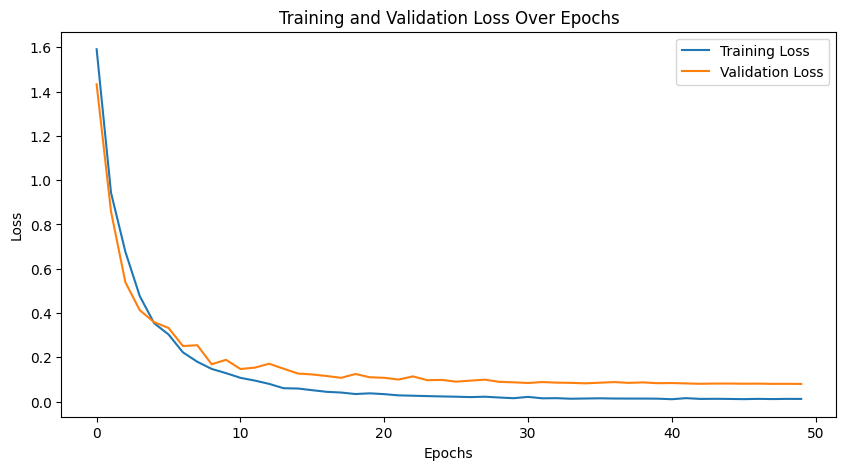

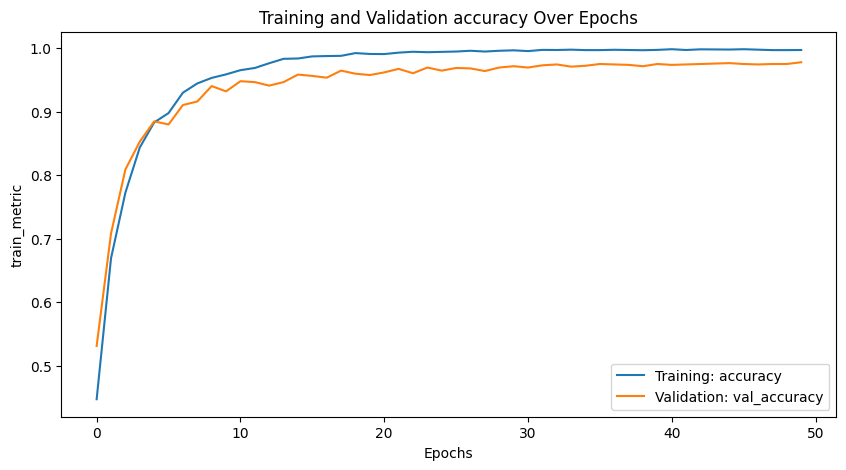

In [24]:
#Modelin eğitim sürecinde kaydedilen performans bilgilerini grafiksel olarak gösterir.
plot_training_history(history)

<p style="background-color: #FFDAB9; padding: 15px; border-radius: 10px;">
 📌 Bu grafiklerde modelin eğitim ve doğrulama süreci boyunca kayıp (loss) ve doğruluk (accuracy) değerlerinin değişimi gözlemleniyor. <br><br> 
    Eğitim ve Doğrulama Kayıpları (Training and Validation Loss Over Epochs) ve Eğitim ve Doğrulama Doğruluğu (Training and Validation Accuracy Over Epochs) grafiklerinde, bazı epochlarda  hem kayıplarda hem de doğrulukta küçük dalgalanmalar gözlemlenmektedir. Bu dalgalanmalr modelin öğrenme sürecinde yaptığı optimizasyonlardan (örneğin, batch normalization veya dropout) kaynaklanabilir ve tamamen normal bir durumdur.<br><br> 
    Epoch'lar ilerledikçe, hem eğitim hem de doğrulama setlerindeki kayıpların azaldığını ve neredeyse sabitlendiğini görüyoruz. Aynı şekilde, doğruluk (accuracy) değerleri de artıyor ve birbirine yakın seviyelerde sabitleniyor. Bu durum, modelin hem eğitim hem de doğrulama verisi üzerinde dengeli bir performans sergilediğini ve aşırı öğrenme (overfitting) yapmadığını gösteriyor. Modelin genel olarak iyi bir şekilde öğrenip genelleme yapabildiğini söyleyebiliriz.<br><br>  
    </p>
    
    

In [25]:
test_result = initial_model.evaluate(x_test, verbose=0)
print('Test loss is : ',test_result[0])
print('Test accuracy is : ',test_result[1])

Test loss is :  0.07322262972593307
Test accuracy is :  0.9766666889190674


In [26]:
initial_model.save_weights("my_model.weights.h5")

<p style="background-color: #FFDAB9; padding: 15px; border-radius: 10px;">
  Bu kod modelin test veri seti üzerindeki performansını ölçmek ve bu doğruluğu kullanıcıya göstermek için kullanılıyor. Böylece modelin test verisi üzerindeki genel performansını değerlendirebiliriz.<br><br>
    Girilen parametrelerin açıklamaları şu şekildedir:<br><br>
        •  <span style="font-weight: bold;">initial_model nesnesi,</span>  evaluate metodunu kullanarak test verisi üzerindeki modelin performansını hesaplar ve kayıp (loss) ve doğruluk (accuracy) değerlerini döndürür.<br><br> 
        •  <span style="font-weight: bold;">verbose=0 parametresi,</span> değerlendirme işlemi sırasında herhangi bir ilerleme çubuğu veya detaylı çıktının ekrana yazılmasını engeller (sessiz modda çalıştırır).<br><br> 
    " test_result " bir liste şeklinde bir değişkendir. Bu liste, modelin test veri seti üzerindeki performansını gösteren değerleri içerir.<br><br> 
        •  <span style="font-weight: bold;">test_result[0]:</span> Bu, test verisi üzerindeki kayıp (loss) değeridir. Yani modelin tahmin ettiği sonuçlar ile gerçek değerler arasındaki farkı ölçen değerdir.<br><br> 
     •  <span style="font-weight: bold;">test_result[1]:</span> Bu, test verisi üzerindeki doğruluk (accuracy) değeridir. Modelin test setinde kaç tane örneği doğru tahmin ettiğini yüzdesel olarak gösterir<br><br>     
    </p>

57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 308ms/step


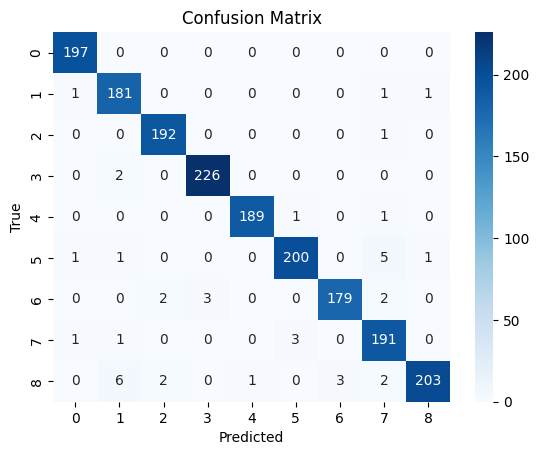

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       197
           1       0.95      0.98      0.97       184
           2       0.98      0.99      0.99       193
           3       0.99      0.99      0.99       228
           4       0.99      0.99      0.99       191
           5       0.98      0.96      0.97       208
           6       0.98      0.96      0.97       186
           7       0.94      0.97      0.96       196
           8       0.99      0.94      0.96       217

    accuracy                           0.98      1800
   macro avg       0.98      0.98      0.98      1800
weighted avg       0.98      0.98      0.98      1800



In [27]:
# Confusion Matrix ve Classification Report
y_pred = initial_model.predict(x_test)  # Test verisi üzerindeki tahminlerin alınması

y_pred_classes = np.argmax(y_pred, axis=1) # En yüksek olasılığa sahip sınıfı almak (her örnek için tahmin edilen sınıf)

y_true_classes = x_test.classes  # Gerçek sınıf değerlerini almak

conf_mat = confusion_matrix(y_true_classes, y_pred_classes) # Karmaşıklık matrisini oluşturmak

sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='d') # Karmaşıklık matrisinin görselleştirilmesi
plt.xlabel('Predicted')  # X eksenine tahmin edilen sınıflar etiketi eklemek
plt.ylabel('True')  # Y eksenine gerçek sınıflar etiketi eklemek
plt.title('Confusion Matrix')   # Grafiğin başlığını eklemek

plt.show()

print(classification_report(y_true_classes, y_pred_classes)) # Sınıflandırma raporunu ekrana yazdırmak (precision, recall, f1-score, support)


<p style="background-color: #FFDAB9; padding: 15px; border-radius: 10px;">
 📌 Confusion matrix kullanarak, modelin her sınıf için ne kadar doğru ve ne kadar yanlış tahmin yaptığını gözlemleyebiliriz. <br>Bu tablo, modelin sınıflar arasındaki performansını ayrıntılı bir şekilde anlamamıza yardımcı olur. <br><br>
    <span style="font-weight: bold;">
    🚀 Modelimizin değerlendirme metriki olarak accuracy değerine baktığımızda, bu oran %98 olarak karşımıza çıkıyor. Bu da demek oluyor ki, modelimiz elindeki 100 balık resminden 98'ini doğru şekilde sınıflandırabilmiş. <br> Bu doğruluk oranı, modelimizin genel olarak balık türlerini büyük oranda doğru tanıdığını ve iyi bir genelleme kapasitesine sahip olduğunu gösteriyor. <br>Yani sınıflandırma görevinde etkili bir performans sergilediğini söyleyebiliriz.</span> <br><br>    
   📌 Precision, Recall, F1-Score değerleri de her bir sınıf için oldukça yüksektir. Bu durum, modelin her bir sınıfı doğru ve dengeli bir şekilde tahmin edebildiğini gösteriyor.<br><br>  
    </p>

<p style="background-color: #FFDAB9; padding: 15px; border-radius: 10px;">
<span style="font-weight: bold;">Veri Setimiz Dengesiz Olsaydı, Yine Model Başarı Değerlendirme Metriği olarak Accuracy'yi Mi Kullanmalıydık? 🧐</span> <br><br> 
 📌 Burada önemli bir noktaya değinmek istiyorum. Veri setimiz dengeli, yani her sınıfın yaklaşık olarak eşit sayıda gözlem birimi var. Bu nedenle, accuracy metriği modelimizin performansını değerlendirmek için mantıklı ve yeterli bir ölçüt olarak kullanılıyor. Ancak, eğer veri setimiz dengesiz olsaydı, yani bazı sınıfların diğerlerine göre çok daha fazla ya da az sayıda olduğu bir durum olsaydı, accuracy metriği yanıltıcı olabilirdi. Çünkü çoğunluk sınıfını doğru tahmin ederek yüksek bir doğruluk elde etmek kolaydır; fakat bu durum diğer sınıfları ihmal etmek anlamına gelebilir. <br><br>  
   📌 Bu nedenle, dengesiz veri setlerinde F1 skoru gibi metrikleri kullanmak daha uygun olacaktır. F1 skoru, precision (kesinlik) ve recall (duyarlılık) arasındaki dengeyi alarak, özellikle dengesiz sınıflar arasında daha dengeli bir performans değerlendirmesi sağlar. Böylece modelin, az temsil edilen sınıflarda da ne kadar başarılı olduğunu daha net görebiliriz.<br><br>  
    </p>
    

<a class="anchor" id="read"></a>

## <span style="color:#FA8072"> Hyperparameter Tuning (Hiperparametre Ayarlama) </span> <a class="anchor" id="load_data"></a>


<p style="background-color: #FFDAB9; padding: 15px; border-radius: 10px;">
 📌 Hyperparameter tuning (hiperparametre ayarlama) sürecinde, modelin eğitim süresini minimize etmek amacıyla Random Search metodu kullanıldı. Random Search, hiperparametre uzayından rastgele örnekler seçerek arama yapar ve genellikle belirli bir zaman sınırlaması olduğunda veya arama uzayının çok büyük olduğu durumlarda tercih edilir. Bu metodun yerine Grid Search veya Bayesian Search gibi diğer yöntemler de kullanılabilirdi. Her bir metodun avantaj ve dezavantajlarına değinecek olursak: <br><br>  
     •  <span style="font-weight: bold;">1. Random Search:</span> Arama uzayı çok büyük olduğunda, rastgele seçimler sayesinde daha kısa sürede sonuçlara ulaşılabilir. Fakat, optimum çözüme ulaşma garantisi yoktur: Parametre uzayında sadece rastgele örnekleme yapıldığından, bazı önemli bölgeler göz ardı edilebilir ve optimum çözüme ulaşamayabilir.<br><br> 
     •  <span style="font-weight: bold;">2. Grid Search:</span> Belirlenen hiperparametre kombinasyonlarının tamamı taranır ve bu sayede optimum sonuca ulaşma olasılığı yüksektir. Fakat, arama uzayı büyükse, deneme sayısı katlanarak artar ve bu da çok fazla zaman ve hesaplama gücü gerektirir.<br><br> 
         •  <span style="font-weight: bold;">3. Bayesian Optimization:</span> Önceki denemelerden elde edilen sonuçlara dayalı olarak hiperparametre aramasını optimize eder ve böylece daha az denemeyle iyi sonuçlara ulaşabilir. Bu yöntem, Grid Search'e kıyasla daha az denemeyle iyi sonuçlara ulaşmayı sağlar ve özellikle arama uzayı büyük olduğunda zamandan tasarruf edebilir. Ancak, yine de çok büyük arama uzaylarında denemeler uzun sürebilir ve bu da yüksek hesaplama gücü gerektirebilir.<br><br>     
    ✅Yapmış olduğum Random Search ile yapılan hiperparametre aramalarında modelde belirgin bir iyileşme gözlenmemiştir. Bu durum, Random Search'ün beklenen bir sonucudur, çünkü bu yöntem genellikle arama uzayını rastgele taradığı için en iyi hiperparametre kombinasyonunu bulmak her zaman garanti değildir.<br><br>   
    </p>

In [28]:
# Hiperparametre optimizasyonu için modelin oluşturulması
# Bu fonksiyon, belirli hiperparametrelerle bir model oluşturur ve modelin çeşitli yapılandırma seçeneklerini test eder.
# Hyperparameter tuning sırasında kullanılır ve modelin performansını en üst düzeye çıkarmak amaçlanır.

def build_model(hp):
    model = Sequential()
    
    # Rescaling layer: Giriş verilerini normalleştirir ve 0-1 aralığına getirir.
    model.add(Rescaling(1./255))
    
    # Flatten layer: Giriş verilerini tek boyutlu bir vektöre dönüştürerek gizli katmanlara aktarır.
    model.add(Flatten(input_shape=(224, 224, 3)))

    # Hidden layers: Belirli hiperparametrelere göre değişen nöron sayısı, aktivasyon fonksiyonu, regularizasyon ve dropout ile gizli katmanlar oluşturur.
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(#Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=256, step=32),
                  Dense(units=hp.Choice('units_' + str(i), values=[64, 128]),
                        activation=hp.Choice('activation_' + str(i), values=['relu', 'leaky_relu']),
                        kernel_regularizer=l2(hp.Float('l2_' + str(i), min_value=0.0001, max_value=0.01, sampling='log'))))
        model.add(BatchNormalization()) # Batch Normalization, aktivasyon sonucu elde edilen değerleri normalize eder
        model.add(Dropout(hp.Float('dropout_' + str(i), min_value=0.1, max_value=0.5, step=0.1))) # Dropout, bazı nöronları rastgele devre dışı bırakır

    # Output layer: Modelin sınıflandırma sonucunu (9 sınıf) üretir.
    model.add(Dense(9, activation='softmax'))

    # Learning rate schedule: Öğrenme oranını zamanla azaltarak daha etkili ve kararlı bir eğitim sağlar.
    initial_learning_rate = hp.Float('initial_learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    lr_schedule = ExponentialDecay(
        initial_learning_rate=initial_learning_rate,
        decay_steps=1000,
        decay_rate=0.96,
        staircase=True
    )

    # Optimizer selection: SGD veya Adam gibi optimizasyon algoritmalarını seçer ve bu algoritmalara özgü hiperparametreleri ayarlar.
    optimizer_choice = hp.Choice('optimizer', values=['sgd', 'adam'])
    if optimizer_choice == 'sgd':
        optimizer = SGD(
            learning_rate=lr_schedule,
            momentum=hp.Float('momentum', min_value=0.0, max_value=0.9, step=0.1)
        )
    elif optimizer_choice == 'adam':
        optimizer = Adam(
            learning_rate=lr_schedule,
            beta_1=hp.Float('beta1', min_value=0.85, max_value=0.99, step=0.01),
            beta_2=hp.Float('beta2', min_value=0.999, max_value=0.9999, step=0.0001),
            epsilon=hp.Float('epsilon', min_value=1e-8, max_value=1e-7, step=1e-8)
        )

    # Model compilation: Modeli derler ve öğrenme sürecinde kullanılacak kayıp fonksiyonu ve metrikleri belirler.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [29]:
random_search_tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=2,
    executions_per_trial=1,
    overwrite=True)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True)


In [30]:
# Using GPU for training
with tf.device('/GPU:0'):
    random_search_tuner.search(x_train,
                               epochs=50,
                               validation_data=x_val,
                               callbacks=[early_stopping])


Trial 2 Complete [00h 47m 27s]
val_loss: 0.8154733180999756

Best val_loss So Far: 0.8154733180999756
Total elapsed time: 01h 45m 50s


In [31]:
best_hps = random_search_tuner.get_best_hyperparameters(num_trials=2)

In [32]:
best_hps_1 = best_hps[0]
best_hps_2 = best_hps[1]

In [33]:
print(f"Best hyperparameters: {best_hps_1.values}")

Best hyperparameters: {'num_layers': 3, 'units_0': 64, 'activation_0': 'relu', 'l2_0': 0.004405417457520309, 'dropout_0': 0.1, 'initial_learning_rate': 0.00027679152802532797, 'optimizer': 'sgd', 'momentum': 0.0, 'units_1': 64, 'activation_1': 'relu', 'l2_1': 0.0001, 'dropout_1': 0.1, 'units_2': 64, 'activation_2': 'relu', 'l2_2': 0.0001, 'dropout_2': 0.1}


In [34]:
print(f"Best hyperparameters: {best_hps_2.values}")

Best hyperparameters: {'num_layers': 1, 'units_0': 128, 'activation_0': 'relu', 'l2_0': 0.0023285010665210285, 'dropout_0': 0.30000000000000004, 'initial_learning_rate': 0.0011945519459253546, 'optimizer': 'sgd', 'momentum': 0.30000000000000004}


In [35]:
best_models = random_search_tuner.get_best_models(num_models=2)

In [36]:
for i, model in enumerate(best_models):
    loss, acc = model.evaluate(x_test, verbose=0)
    print(f"Model {i+1}, Validation loss: {loss}, Validation Accuracy: {acc}")

Model 1, Validation loss: 0.8218487501144409, Validation Accuracy: 0.9333333373069763
Model 2, Validation loss: 1.0890917778015137, Validation Accuracy: 0.8500000238418579


<p style="background-color: #FFDAB9; padding: 15px; border-radius: 10px;">
 📌 Görüldüğü üzere, Random Search ile yapılan hiperparametre optimizasyonu sonucunda iki model üzerinde belirgin bir iyileşme gözlenememiştir: <br><br>  
     •  Model 1: Validation loss: 0.82, Validation Accuracy: %93<br><br> 
     • Model 2: Validation loss: 1.09, Validation Accuracy: %85<br><br> 
    <span style="font-weight: bold;">
    🚀 Bu sonuçlar doğrultusunda, hiperparametre optimizasyonu yapmadan mevcut modelimizle devam ettik. Modelimiz mevcut haliyle test setinde iyi bir performans sergileyerek yüksek doğruluk oranına ulaşmıştır.</span> <br><br>   
    ✅ Ayrıca, hiperparametre optimizasyonunda arama uzayını dar tutmak zorunda kaldık. Bunun nedeni, GPU limitlerimize ulaştığımız için daha uzun süren deneyler yapmanın mümkün olmamasıydı. Bu kısıtlamalar nedeniyle, daha geniş bir arama yapamamış olsak da, model mevcut haliyle tatmin edici sonuçlar vermeye devam etmektedir.
    </p>

## FINAL MODEL

<p style="background-color: #FFDAB9; padding: 15px; border-radius: 10px;">
 📌 Bu bölümde, nihai model test edilmiştir.<br>   </p>

In [37]:
initial_model.load_weights('my_model.weights.h5')  # Kaydedilen ağırlıkları yüklüyoruz

In [38]:
initial_model.summary()  # Modelin özetini (katman yapısını) yazdırıyoruz

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │    38,535,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 115,762,077 (441.60 MB)

 Trainable params: 38,587,017 (147.20 MB)

 Non-trainable params: 1,024 (4.00 KB)

 Optimizer params: 77,174,036 (294.40 MB)

In [39]:
test_result = initial_model.evaluate(x_test, verbose=0)
print('Test loss is : ',test_result[0])
print('Test accuracy is : ',test_result[1])

Test loss is :  0.07322262972593307
Test accuracy is :  0.9766666889190674


57/57 ━━━━━━━━━━━━━━━━━━━━ 17s 296ms/step


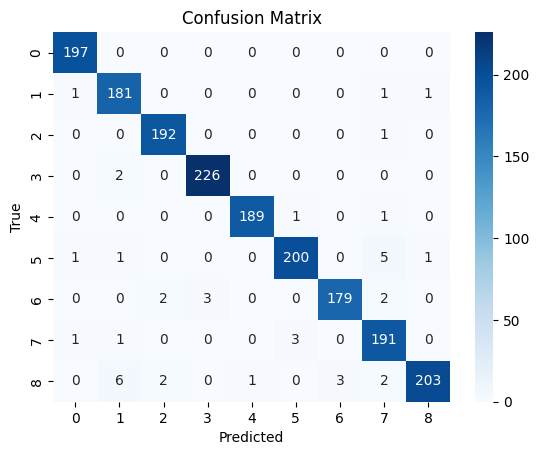

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       197
           1       0.95      0.98      0.97       184
           2       0.98      0.99      0.99       193
           3       0.99      0.99      0.99       228
           4       0.99      0.99      0.99       191
           5       0.98      0.96      0.97       208
           6       0.98      0.96      0.97       186
           7       0.94      0.97      0.96       196
           8       0.99      0.94      0.96       217

    accuracy                           0.98      1800
   macro avg       0.98      0.98      0.98      1800
weighted avg       0.98      0.98      0.98      1800



In [40]:
# Confusion Matrix ve Classification Report
y_pred = initial_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = x_test.classes

conf_mat = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true_classes, y_pred_classes))

In [41]:
# Test verisini kopyalayıp predict_data adında yeni bir DataFrame oluşturuyoruz.
predict_data = test_data.copy()

# Boş bir labels sözlüğü tanımlıyoruz.
labels={}

# Mevcut sınıf indekslerini tersine çevirerek (indeks -> sınıf etiketi) labels sözlüğüne ekliyoruz.
for l,v in x_test.class_indices.items():
    labels.update({v:l})

# Modelin tahmin ettiği sınıf indekslerini 'pred' adlı bir sütuna atıyoruz.
predict_data['pred'] = y_pred_classes

# Tahmin edilen sınıf indekslerini sınıf etiketlerine çeviriyoruz.
predict_data['pred'] = predict_data['pred'].apply(lambda x: labels[x])

In [42]:
# DataFrame'in indekslerini sıfırlıyoruz, eski indeksleri korumadan (drop=True) yeni bir sıralı indeks oluşturuyoruz.
predict_data = predict_data.reset_index(drop=True)

# İlk 10 satırı görüntülüyoruz, tahmin edilen sonuçları kontrol etmek için.
predict_data.head(10)

,path,label,pred
0,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Red Sea Bream,Red Sea Bream
1,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Black Sea Sprat,Black Sea Sprat
2,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Striped Red Mullet,Striped Red Mullet
3,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Red Mullet,Red Mullet
4,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Gilt-Head Bream,Gilt-Head Bream
5,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Red Sea Bream,Red Sea Bream
6,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Red Mullet,Red Mullet
7,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Red Sea Bream,Red Sea Bream
8,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Trout,Trout
9,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Striped Red Mullet,Striped Red Mullet


In [43]:
# Gerçek etiketler ('label') ile tahmin edilen etiketler ('pred') eşleşmeyen satırları filtreleyip gösteriyoruz.
# Bu sayede modelin yanlış sınıflandırdığı verileri görebiliriz.

predict_data[predict_data['label']!=predict_data['pred']]

,path,label,pred
14,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Sea Bass,Striped Red Mullet
59,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel,Striped Red Mullet
138,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Red Sea Bream,Sea Bass
145,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Sea Bass,Black Sea Sprat
150,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Shrimp,Striped Red Mullet
211,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Sea Bass,Striped Red Mullet
227,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Trout,Shrimp
297,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Shrimp,Red Mullet
332,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Trout,Gilt-Head Bream
385,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Trout,Gilt-Head Bream


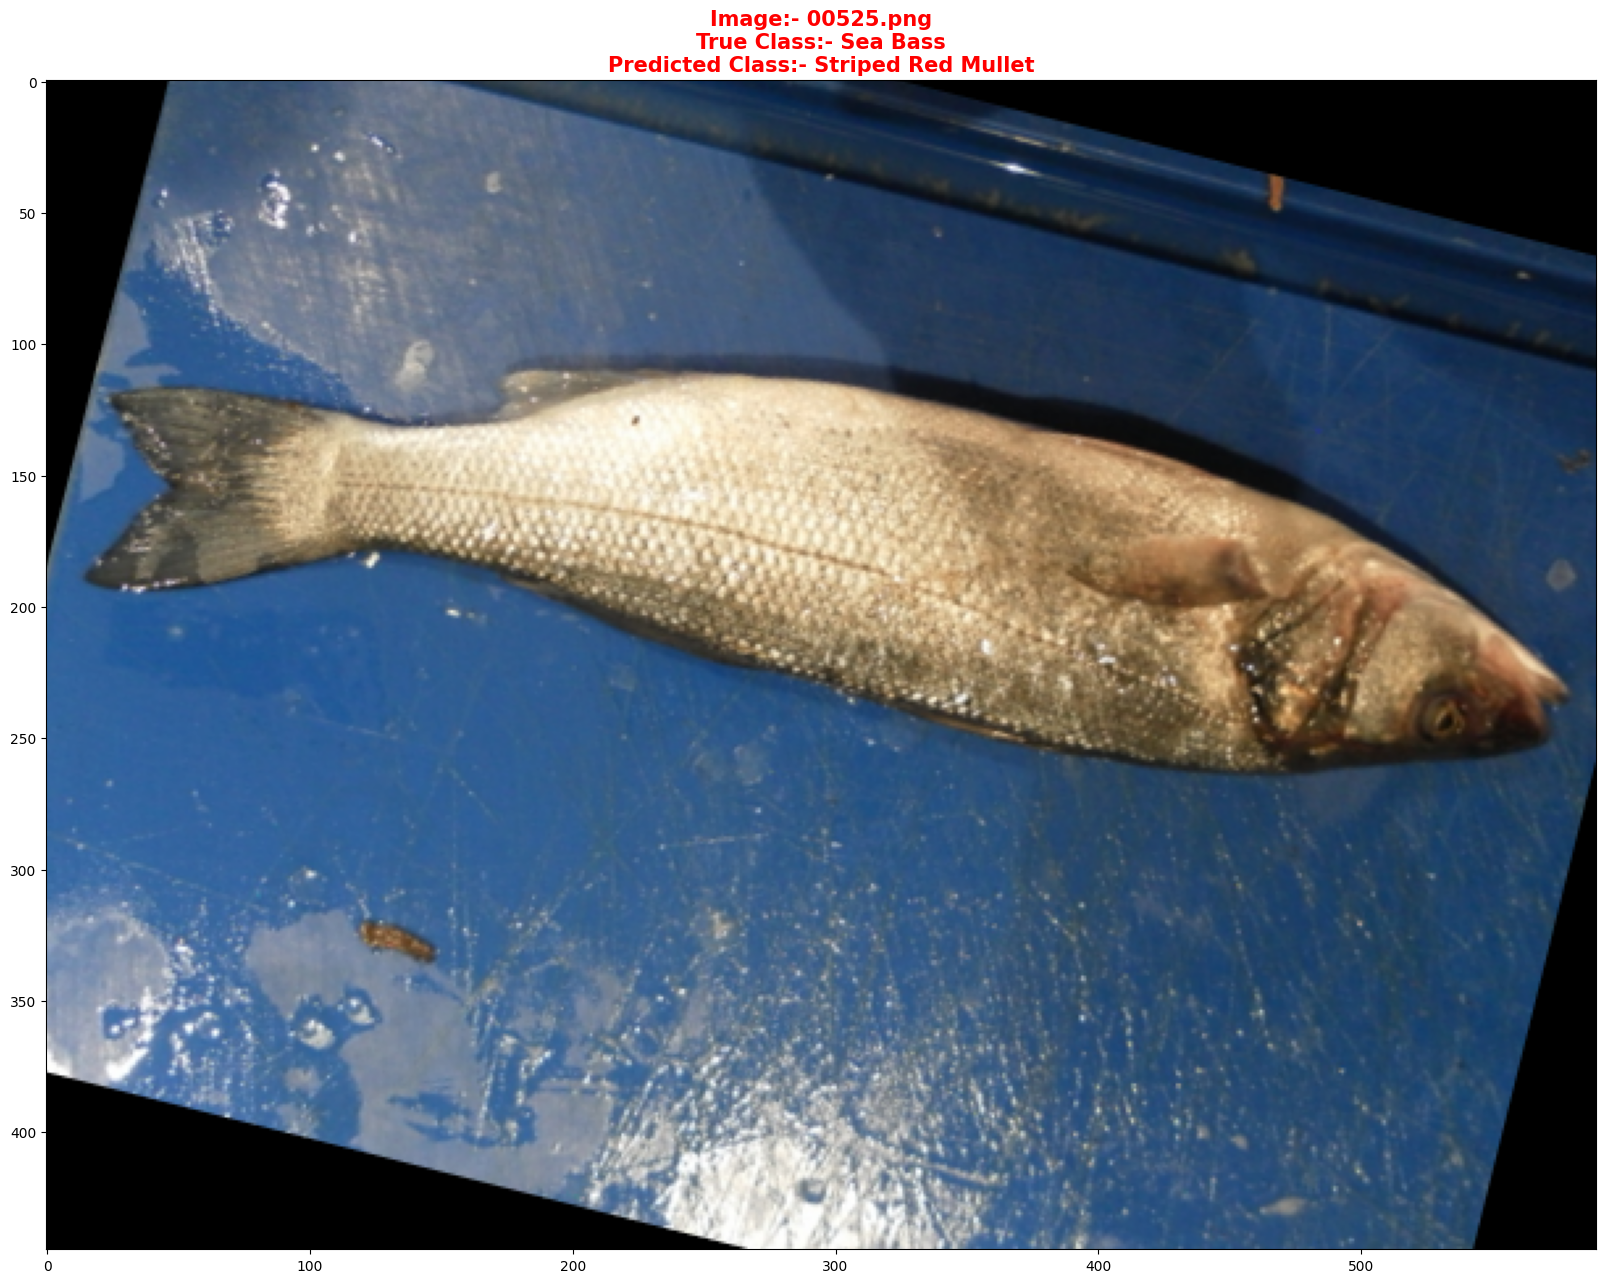

In [44]:
# Modelinin tahmin sonuçlarını görselleştirmek ve karşılaştırmak için kullanılır.

plt.figure(figsize=(20,20))
plt.imshow(plt.imread(predict_data.path[14]))
title1 = predict_data.path[14].split('/')[-2]
title2 = predict_data.path[14].split('/')[-1]
title3 = predict_data.pred[14]
plt.title(f'Image:- {title2}\nTrue Class:- {title1}\nPredicted Class:- {title3}', color = 'r', weight = 'bold', fontsize = 15)
plt.show()